In [ ]:
import numpy as np
import pandas as pd
import random
import time
import math
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from dateutil import parser
from pathlib import Path
import json 
import shutil
import logging
logger = logging.getLogger(str(os.getpid()))

from wattile.data_reading import read_dataset_from_file
from wattile.data_processing import correct_predictor_columns, correct_timestamps, resample_or_rolling_stats, input_data_split
from wattile.time_processing import add_processed_time_columns
PROJECT_DIRECTORY = Path().resolve().parent.parent

### reading configs

In [ ]:
"""
For this example, we will be using the default configs.
Check out the docs for an explaination of each config.
"""
##################################################################################
# choose the configs file to use as an input
##################################################################################
# main configs file
with open(PROJECT_DIRECTORY / "wattile" / "configs" / "configs.json", "r") as f:
    configs = json.load(f)
##################################################################################
# code testing configs file
# with open(PROJECT_DIRECTORY / "tests" / "fixtures" / "test_configs.json", "r") as f:
#     configs = json.load(f)
##################################################################################

exp_dir = PROJECT_DIRECTORY / "notebooks" / "exp_dir"
if exp_dir.exists():
    shutil.rmtree(exp_dir)
exp_dir.mkdir()

configs["data_output"]["exp_dir"] = str(PROJECT_DIRECTORY / exp_dir)
configs["data_input"]["data_dir"] = str(PROJECT_DIRECTORY / "data" / "Synthetic Site")

configs

### reading data

In [ ]:
data = read_dataset_from_file(configs)
data

### feature extraction

In [ ]:
# assert we have the correct columns and order them
data = correct_predictor_columns(configs, data)

# sort and trim data specified time period
data = correct_timestamps(configs, data)

# Add time-based features
data = add_processed_time_columns(data, configs)

# Add statistics features
data = resample_or_rolling_stats(data, configs)

data

In [ ]:
# data.to_csv("./output.csv")

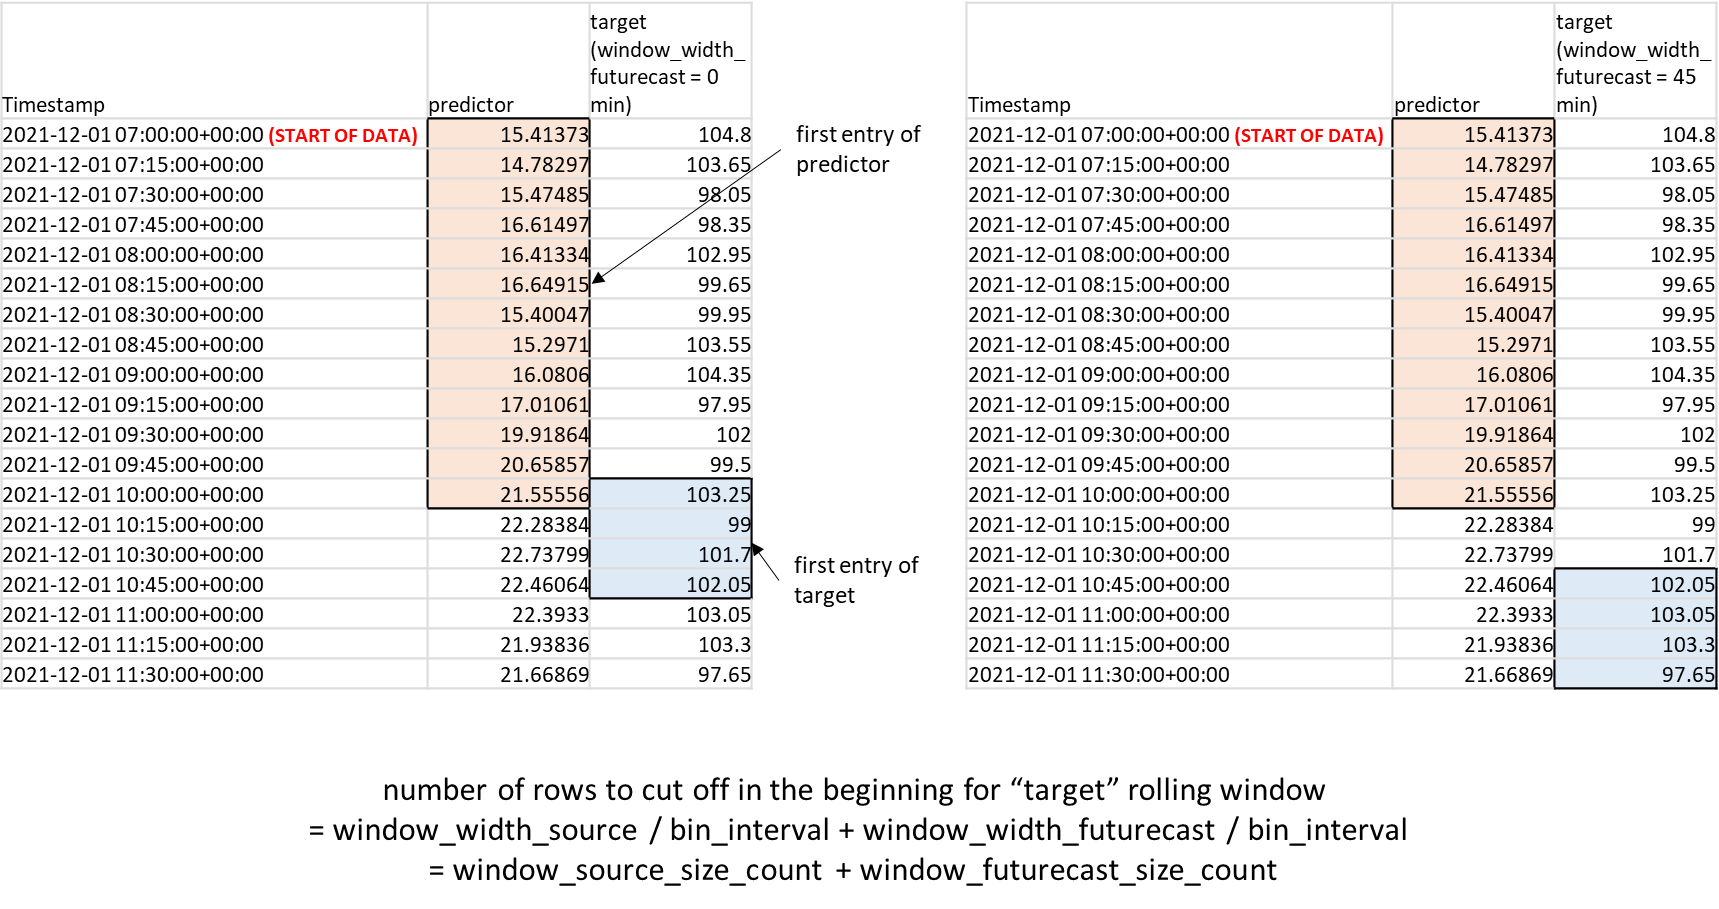

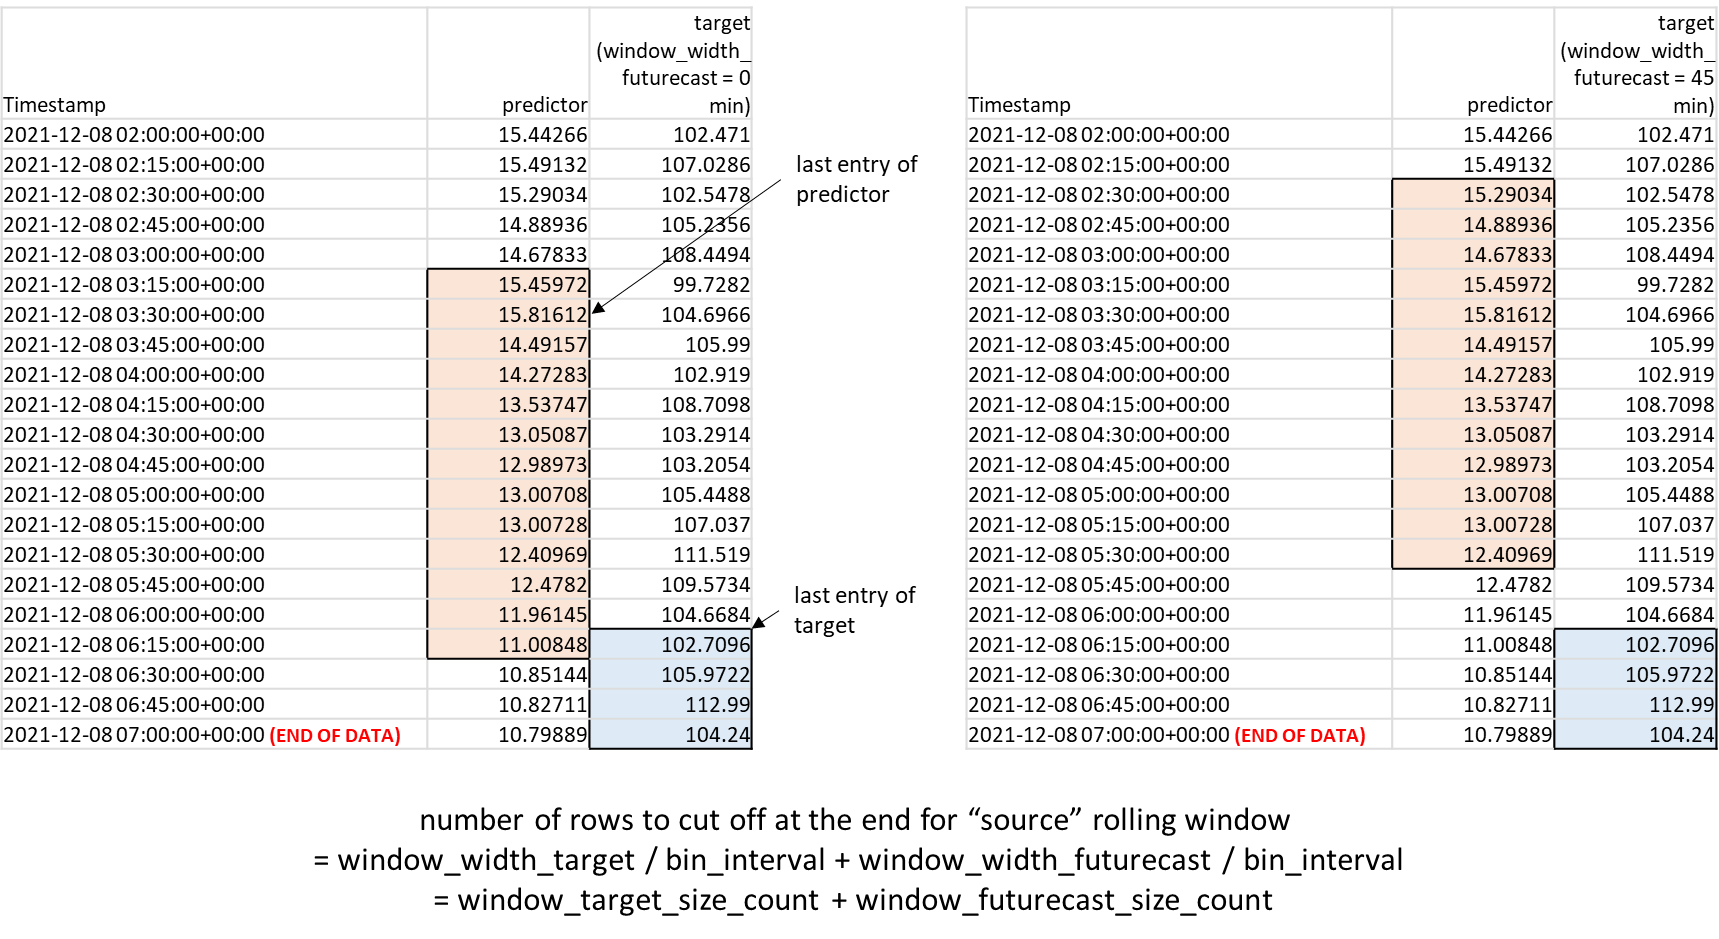

# =======================================
# modified workflow
# =======================================

In [ ]:
def _create_split_mask(timestamp, data_size, configs):

    # set configuration parameters
    np.random.seed(seed=configs["data_processing"]["random_seed"])
    active_sequential = configs["data_processing"]["sequential_splicer"]["active"]
    train_ratio = int(configs["data_processing"]["data_split"].split(":")[0]) / 100
    val_ratio = int(configs["data_processing"]["data_split"].split(":")[1]) / 100
    test_ratio = int(configs["data_processing"]["data_split"].split(":")[2]) / 100
    window_witdh = configs["data_processing"]["sequential_splicer"]["window_width"]
    train_size_factor = configs["data_processing"]["train_size_factor"]

    # split data based on random sequential chunks
    if active_sequential:
        # set indices for training set
        splicer = ((timestamp - timestamp[0]) // pd.Timedelta(window_witdh)).values
        num_chunks = splicer[-1]
        num_train_chunks = (train_ratio * num_chunks) - (
            (train_ratio * num_chunks) % train_size_factor
        )
        if num_train_chunks == 0:
            raise Exception(
                "Total number of data chunks is zero. train_size_factor value might be too "
                "large compared to the data size. Exiting.."
            )
        msk = np.zeros(timestamp.shape[0]) + 2
        train_chunks = np.random.choice(
            np.arange(num_chunks), replace=False, size=int(num_train_chunks)
        )
        for chunk in train_chunks:
            indices = np.where(splicer == chunk)
            msk[indices] = 0

        # set indices for validation and test set
        remaining_chunks = np.setdiff1d(np.arange(num_chunks), train_chunks)
        if test_ratio == 0:
            msk[msk != 0] = 1
        else:
            num_val_chunks = int(
                (val_ratio / (1 - train_ratio)) * remaining_chunks.shape[0]
            )
            val_chunks = np.random.choice(
                remaining_chunks, replace=False, size=num_val_chunks
            )
            for chunk in val_chunks:
                indices = np.where(splicer == chunk)
                msk[indices] = 1

    # split data based on random timestamp sampling
    else:
        # set indices for training set
        num_ones = (train_ratio * data_size) - (
            (train_ratio * data_size) % train_size_factor
        )
        msk = np.zeros(data_size) + 2
        indices = np.random.choice(
            np.arange(data_size), replace=False, size=int(num_ones)
        )
        msk[indices] = 0

        # set indices for validation and test set
        remaining_indices = np.where(msk != 0)[0]
        if test_ratio == 0:
            msk[remaining_indices] = 1
        else:
            num_val = int((val_ratio / (1 - train_ratio)) * remaining_indices.shape[0])
            val_indices = np.random.choice(
                remaining_indices, replace=False, size=num_val
            )
            msk[val_indices] = 1

    return msk

In [ ]:
def input_data_split(data, configs):
    """
    Split a data set into a training set and a validation (val) set.
    Methods: "Random" or "Sequential", specified in configs

    :param data: (DataFrame)
    :param configs: (Dict)
    :return:
    """
    # setting configuration parameters
    arch_version = configs["learning_algorithm"]["arch_version"]
    file_prefix = Path(configs["data_output"]["exp_dir"])
    mask_file = os.path.join(file_prefix, "mask.h5")

    # assign timestamp and data size depending on arch_version
    if (arch_version == "alfa") | (arch_version == "bravo"):
        timestamp = data.index
        data_size = data.shape[0]

    elif arch_version == "charlie":
        timestamp = data["timestamp"]
        data_size = data["predictor"].shape[0]

    msk = _create_split_mask(timestamp, data_size, configs)

    # assign train, validation, and test data
    if (arch_version == "alfa") | (arch_version == "bravo"):
        train_df = data[msk == 0]
        val_df = data[msk == 1]
        test_df = data[msk == 2]
        # Get rid of datetime index
        train_df.reset_index(drop=True, inplace=True)
        val_df.reset_index(drop=True, inplace=True)
        # save test_df to file for later use
        test_df.to_hdf(
            os.path.join(file_prefix, "internal_test.h5"), key="df", mode="w"
        )

    elif arch_version == "charlie":
        train_df = {}
        val_df = {}
        train_df_predictor = data["predictor"][msk == 0, :, :]
        train_df_target = data["target"][msk == 0, :, :]
        val_df_predictor = data["predictor"][msk == 1, :, :]
        val_df_target = data["target"][msk == 1, :, :]
        test_df_predictor = data["predictor"][msk == 2, :, :]
        test_df_target = data["target"][msk == 2, :, :]
        train_df["predictor"] = train_df_predictor
        train_df["target"] = train_df_target
        val_df["predictor"] = val_df_predictor
        val_df["target"] = val_df_target
        # save test_df to file for later use
        np.save(
            os.path.join(file_prefix, "internal_test_predictor.npy"), test_df_predictor
        )
        np.save(os.path.join(file_prefix, "internal_test_target.npy"), test_df_target)

    # save mask file to preserve timeseries index
    mask = pd.DataFrame()
    mask["msk"] = msk
    mask["index"] = timestamp
    mask = mask.set_index("index")
    mask.to_hdf(mask_file, key="df", mode="w")

    return train_df, val_df

### roll_predictors_target

In [ ]:
# setting configuration settings
file_prefix = Path(configs["data_output"]["exp_dir"])
configs["learning_algorithm"]["arch_version"] = "charlie"
configs["data_processing"]["sequential_splicer"]["active"] = False
configs["learning_algorithm"]["num_epochs"] = 100

# reading configuration settings
configs["data_processing"]["input_output_window"] = {
    "window_width_source": "180min",
    "window_width_futurecast":"45min",
    "window_width_target": "45min",
 }

import copy

In [ ]:
# def roll_predictors_target(data, configs):
    
"""
Create rolling windows of predictor and target variables in a DataFrame.
Used specifically for charlie learning methods.

:param data: (DataFrame)
:param configs: (Dict)
:return: (Dict)
"""

# setting configuration parameters
window_width_source = configs["data_processing"]["input_output_window"][
    "window_width_source"
]
window_width_futurecast = configs["data_processing"]["input_output_window"][
    "window_width_futurecast"
]
window_width_target = configs["data_processing"]["input_output_window"][
    "window_width_target"
]
bin_interval = configs["data_processing"]["resample"]["bin_interval"]
target_var = configs["data_input"]["target_var"]
target = copy.deepcopy(data[target_var])

#################################################################################
# ToDos
# do we don't shift here so that predictors can retain original timestamps of target
#################################################################################
# shift target for futurecast
# data[target_var] = target.shift(freq="-" + window_width_futurecast)

# initialize lists
data_predictor = []
data_target = []

# calculate number of rows based on window size defined by time
#################################################################################
# ToDos
# add count one?
#################################################################################
window_source_size_count = pd.Timedelta(window_width_source) // pd.Timedelta(
        bin_interval
    )
window_target_size_count = pd.Timedelta(window_width_target) // pd.Timedelta(
    bin_interval
)
window_futurecast_size_count = pd.Timedelta(
    window_width_futurecast
) // pd.Timedelta(bin_interval)

#################################################################################
# ToDos
# cutoff/shift some timestamps based on input_output_window parameters?
#################################################################################
# set aside timeindex
timestamp = data.iloc[
    window_source_size_count : -(
        window_target_size_count + window_target_size_count
    ),
    :,
].index

In [ ]:
timestamp

In [ ]:
window_source_size_count

In [ ]:
window_target_size_count

In [ ]:
window_futurecast_size_count

In [ ]:
#################################################################################
# ToDos
# do we take out target or retain target?
#################################################################################
# create 3D predictor data
data_shifted_predictor = data.iloc[
        : -(window_target_size_count + window_futurecast_size_count), :
    ].loc[:, data.columns != target_var]
for window in data_shifted_predictor.rolling(window=window_width_source, closed="both"):
    if window.shape[0] == window_source_size_count+1:
        data_predictor.append(
            window.values.reshape(
                (1, window_source_size_count+1, data_shifted_predictor.shape[1])
            )
        )
# reshape data dimension
data_predictor = np.concatenate(np.array(data_predictor), axis=0)

In [ ]:
data_predictor.shape

In [ ]:
#################################################################################
# ToDos
# reflect futurecast to the algorithm
# check if target entry size is the same as window_width_target
#################################################################################
# create 3D target data
data_shifted_target = data.iloc[
        (window_source_size_count + window_futurecast_size_count):, :
    ][target_var]
for window in data_shifted_target.rolling(window=window_width_target, closed="both"):
    if window.shape[0] == window_target_size_count+1:
        data_target.append(window.values.reshape((1, window_target_size_count+1, 1)))
# reshape data dimension
data_target = np.concatenate(np.array(data_target), axis=0)

In [ ]:
data_target.shape

In [ ]:
pd.DataFrame(data_predictor[0,:,:])

In [ ]:
pd.DataFrame(data_target[0,:,:])

In [ ]:
pd.DataFrame(data_predictor[-1,:,:])

In [ ]:
pd.DataFrame(data_target[-1,:,:])

In [ ]:
# combine 3D predictor and target data into dictionary
data = {}
data["predictor"] = data_predictor
data["target"] = data_target
data["timestamp"] = timestamp

# return data

In [ ]:
###################################################
# roll_full_data_s2s
###################################################
# data = roll_predictors_target(data, configs)

In [ ]:
###################################################
# input_data_split
###################################################
train_df, val_df = input_data_split(data, configs)

### charlie model

In [ ]:
class S2S_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        if self.cell_type not in ["vanilla", "gru", "lstm"]:
            raise ValueError(
                self.cell_type,
                " is not an appropriate cell type. Please select one of rnn, gru, or lstm.",
            )
        if self.cell_type == "vanilla":
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == "gru":
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == "lstm":
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(self.hidden_size, 1)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters.
    # Refer to Saxe at al. paper that explains why to use orthogonal init weights
    def init(self):
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == "lstm":
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size : 2 * self.hidden_size], 1.0)

    def consume(self, x):
        # encoder forward function
        # for rnn and gru
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            h = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h)
        # for lstm
        elif self.cell_type == "lstm":
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h

    def predict(self, pred_usage, h, target_length):
        # decoder forward function
        preds = []
        # for rnn and gru
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == "lstm":
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h[0])
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds


#########################################################################################
# Bahdanau Attention model
# refer to : AuCson github code
# building the model
class S2S_BA_Model(nn.Module):
    """
    class `S2S_BA_Model`: S2S model with Bahdanau Attention model
    (https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)
    """

    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_BA_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda
        self.cell_type = cell_type

        if self.cell_type not in ["vanilla", "gru", "lstm"]:
            raise ValueError(
                self.cell_type,
                " is not an appropriate cell type. Please select one of rnn, gru, or lstm.",
            )
        if self.cell_type == "vanilla":
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1 + self.hidden_size, self.hidden_size)
        if self.cell_type == "gru":
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1 + self.hidden_size, self.hidden_size)
        if self.cell_type == "lstm":
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1 + self.hidden_size, self.hidden_size)

        self.Wattn_energies = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.Wusage = nn.Linear(self.hidden_size, 1)
        self.Wout = nn.Linear(1 + self.hidden_size * 2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(self.hidden_size))
        stdv = 1.0 / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == "lstm":
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size : 2 * self.hidden_size], 1.0)

    def consume(self, x):
        # for rnn and gru
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.Wusage(h)
        # for lstm
        elif self.cell_type == "lstm":
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.Wusage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        # for rnn and gru
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            for step in range(target_length):
                h_copies = h.expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(
                    self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2))
                )
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0, 1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h, context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == "lstm":
            for step in range(target_length):
                h_copies = h[0].expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(
                    self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2))
                )
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0, 1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h[0], context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds


#########################################################################################
# Luong Attention module
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method

        if self.method not in ["dot", "general", "concat"]:
            raise ValueError(
                self.method,
                " is not an appropriate attention method, "
                "please select one of dot, general, or concat.",
            )
        self.hidden_size = hidden_size
        if self.method == "general":
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        if self.method == "concat":
            self.attn = nn.Linear(2 * self.hidden_size, self.hidden_size)
            self.v = nn.Parameter(torch.rand(self.hidden_size))
            stdv = 1.0 / math.sqrt(self.v.size(0))
            self.v.data.normal_(mean=0, std=stdv)

    def dot_score(self, hidden, encoder_output):
        attn_energies = torch.sum(hidden * encoder_output, dim=2)
        return attn_energies

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        attn_energies = torch.sum(hidden * energy, dim=2)
        return attn_energies

    def concat_score(self, hidden, encoder_output):
        energy = torch.tanh(
            self.attn(
                torch.cat(
                    (hidden.expand(encoder_output.shape[0], -1, -1), encoder_output), 2
                )
            )
        )
        return torch.sum(self.v * energy, dim=2)

    # calculate the attention weights (energies) based on the given method
    def forward(self, hidden, encoder_outputs):
        if self.method == "dot":
            attn_energies = self.dot_score(hidden, encoder_outputs)
        elif self.method == "general":
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == "concat":
            attn_energies = self.concat_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        attn_weights = torch.softmax(attn_energies, dim=1).unsqueeze(1)
        return attn_weights


#########################################################################################
#  building the S2S LA model
class S2S_LA_Model(nn.Module):
    """
    S2S model with Luong Attention module
    (https://machinelearningmastery.com/the-luong-attention-mechanism/).
    `attn` module is part of `S2S_LA_Model`
    """

    def __init__(self, cell_type, attn_method, input_size, hidden_size, use_cuda):
        super(S2S_LA_Model, self).__init__()
        self.cell_type = cell_type
        self.attn_method = attn_method
        self.input_size = input_size
        self.hidden_size = hidden_size

        if self.cell_type == "vanilla":
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == "gru":
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == "lstm":
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(hidden_size, 1)
        self.lin_concat = nn.Linear(hidden_size * 2, hidden_size)
        self.attn = Attn(self.attn_method, self.hidden_size)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == "lstm":
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size : 2 * self.hidden_size], 1.0)

    def consume(self, x):
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.lin_usage(h)
        elif self.cell_type == "lstm":
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        if self.cell_type == "vanilla" or self.cell_type == "gru":
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h, encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
                context = context.squeeze(1)
                concat_input = torch.cat((h, context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        elif self.cell_type == "lstm":
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h[0], encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
                context = context.squeeze(1)
                concat_input = torch.cat((h[0], context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

In [ ]:
def __init__(self, configs):
    self.configs = configs
    self.file_prefix = Path(configs["data_output"]["exp_dir"])
    self.file_prefix.mkdir(parents=True, exist_ok=True)

def main(self, train_df, val_df):  # noqa: C901 TODO: remove noqa
    """
    process the data into three-dimensional for S2S model, train the model, and test the restuls
    """
    window_target_size = self.configs["data_processing"]["input_output_window"][
        "window_width_target"
    ]
    hidden_size = self.configs["learning_algorithm"]["hidden_size"]
    cell_type = self.configs["learning_algorithm"]["arch_type_variant"]
    la_method = "none"
    attention_model = "BA"
    cuda = False
    num_epochs = self.configs["learning_algorithm"]["num_epochs"]
    train_batch_size = self.configs["learning_algorithm"]["train_batch_size"]
    val_batch_size = self.configs["learning_algorithm"]["val_batch_size"]
    loss_function_qs = self.configs["learning_algorithm"]["quantiles"]
    seed = self.configs["data_processing"]["random_seed"]
    bin_interval = self.configs["data_processing"]["resample"]["bin_interval"]
    window_target_size_count = int(
        pd.Timedelta(window_target_size) / pd.Timedelta(bin_interval)
    )
    lr = self.configs["learning_algorithm"]["lr_config"]["base"]
    weight_decay = self.configs["learning_algorithm"]["weight_decay"]

    t0 = time.time()
    np.random.seed(seed)
    torch.manual_seed(seed)

    # loss function, qs here is an integer, not a list of integer
    def quantile_loss(output, target, qs, window_target_size):
        """
        loss function with quntile number as parameter.
        For now, it cannot support list of quantiles as parameters.

        :param output: (Tensor)
        :param target: (Tensor)
        :param qs: (int)
        :param window_target_size: (int)
        :return: (Tensor) Loss for this study (single number)
        """

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        resid = target - output
        tau = torch.tensor([qs], device=device).repeat_interleave(
            window_target_size
        )

        alpha = self.configs["learning_algorithm"]["smoothing_alpha"]
        log_term = torch.zeros_like(resid, device=device)
        log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (
            resid[resid < 0] / alpha
        )
        log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
        loss = resid * tau + alpha * log_term
        loss = torch.mean(torch.mean(loss, 0))

        return loss

    train_df_predictor = train_df["predictor"].astype(np.float32).copy()
    train_df_target = train_df["target"].astype(np.float32).copy()
    val_df_predictor = val_df["predictor"].astype(np.float32).copy()
    val_df_target = val_df["target"].astype(np.float32).copy()

    input_dim = self.configs["input_dim"] = train_df_predictor.shape[-1]

    # call the respective model
    if attention_model == "none":
        model = S2S_Model(cell_type, input_dim, hidden_size, use_cuda=cuda)

    elif attention_model == "BA":
        model = S2S_BA_Model(cell_type, input_dim, hidden_size, use_cuda=cuda)

    elif attention_model == "LA":
        model = S2S_LA_Model(
            cell_type, la_method, input_dim, hidden_size, use_cuda=cuda
        )

    if cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model.cuda()

    print("MODEL ARCHITECTURE IS: ")
    print(model)

    print(
        "\nModel parameters are on cuda: {}".format(
            next(model.parameters()).is_cuda
        )
    )

    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #     loss_fn = nn.MSELoss(reduction='sum')
    loss_fn = quantile_loss

    print("\nStarting training...")

    train_loss = []
    test_loss = []
    n_iter = 0

    for epoch in range(num_epochs):
        t_one_epoch = time.time()
        print("Epoch {}".format(epoch + 1))

        # training
        total_usage_loss = 0
        for b_idx in range(0, train_df_predictor.shape[0], train_batch_size):

            x = torch.from_numpy(
                train_df_predictor[b_idx : b_idx + train_batch_size]
            ).float()
            y = torch.from_numpy(
                train_df_target[b_idx : b_idx + train_batch_size]
            ).float()

            if cuda:
                x = x.cuda()
                y = y.cuda()

            # encoder forward, for respective models (with and without attention)
            if attention_model == "none":
                y_pred, h = model.consume(x)

            elif attention_model == "BA":
                y_pred, h, encoder_outputs = model.consume(x)

            elif attention_model == "LA":
                y_pred, h, encoder_outputs = model.consume(x)

            # decoder forward, for respective models
            if attention_model == "none":
                pred = model.predict(y_pred, h, window_target_size_count)

            elif attention_model == "BA":
                pred = model.predict(
                    y_pred, h, encoder_outputs, window_target_size_count
                )

            elif attention_model == "LA":
                pred = model.predict(
                    y_pred, h, encoder_outputs, window_target_size_count
                )

            # compute lose
            loss_usage = loss_fn(
                pred,
                y,
                qs=loss_function_qs,
                window_target_size=window_target_size_count,
            )

            # backprop and update
            opt.zero_grad()

            loss_usage.sum().backward()

            opt.step()

            total_usage_loss += loss_usage.item()

            n_iter += 1

            # Save the model every ___ iterations
            if n_iter % self.configs["learning_algorithm"]["eval_frequency"] == 0:
                filepath = os.path.join(self.file_prefix, "torch_model")
                save_model(model, epoch, n_iter, filepath)

        train_loss.append(total_usage_loss)
        print("\tTRAINING: {} total train USAGE loss.\n".format(total_usage_loss))

        # testing
        y = None
        y_pred = None
        pred = None
        total_usage_loss = 0
        all_preds = []
        for b_idx in range(0, val_df_predictor.shape[0], val_batch_size):
            with torch.no_grad():
                x = torch.from_numpy(
                    val_df_predictor[b_idx : b_idx + val_batch_size]
                ).float()
                y = torch.from_numpy(val_df_target[b_idx : b_idx + val_batch_size])

                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                # encoder forward, for respective models
                if attention_model == "none":
                    y_pred, h = model.consume(x)

                elif attention_model == "BA":
                    y_pred, h, encoder_outputs = model.consume(x)

                elif attention_model == "LA":
                    y_pred, h, encoder_outputs = model.consume(x)

                # decoder forward, for respective models
                if attention_model == "none":
                    pred = model.predict(y_pred, h, window_target_size_count)

                elif attention_model == "BA":
                    pred = model.predict(
                        y_pred, h, encoder_outputs, window_target_size_count
                    )

                elif attention_model == "LA":
                    pred = model.predict(
                        y_pred, h, encoder_outputs, window_target_size_count
                    )

                # compute loss
                loss_usage = loss_fn(
                    pred,
                    y,
                    qs=loss_function_qs,
                    window_target_size=window_target_size_count,
                )

                if epoch == num_epochs - 1:
                    all_preds.append(pred)

                total_usage_loss += loss_usage.item()

        test_loss.append(total_usage_loss)

        print("\tTESTING: {} total test USAGE loss".format(total_usage_loss))
        print("\tTESTING:\n")
        print("\tSample of prediction:")
        print("\t\t TARGET: {}".format(y[-1].cpu().detach().numpy().flatten()))
        print(
            "\t\t   PRED: {}\n\n".format(pred[-1].cpu().detach().numpy().flatten())
        )

        t2_one_epoch = time.time()
        time_one_epoch = t2_one_epoch - t_one_epoch
        print(
            "TIME OF ONE EPOCH: {} seconds and {} minutes".format(
                time_one_epoch, time_one_epoch / 60.0
            )
        )

    # Once model training is done, save the current model state
    filepath = os.path.join(self.file_prefix, "torch_model")
    save_model(model, epoch, n_iter, filepath)

    # Write the configurations used for this training process to a json file
    path = self.file_prefix / "configs.json"
    with open(path, "w") as fp:
        json.dump(self.configs, fp, indent=1)

    # saving results
    predictions = pd.DataFrame(all_preds[0].numpy().squeeze())
    predictions = predictions.add_prefix("{}_".format(str(loss_function_qs)))
    targets = pd.DataFrame(val_df_target.squeeze())
    predictions.to_hdf(
        os.path.join(self.file_prefix, "predictions.h5"), key="df", mode="w"
    )
    targets.to_hdf(
        os.path.join(self.file_prefix, "measured.h5"), key="df", mode="w"
    )

    # total time of run
    t1 = time.time()
    total = t1 - t0
    print("\nTIME ELAPSED: {} seconds OR {} minutes".format(total, total / 60.0))
    print("\nEnd of run")